The unitary executive theory of the presidency holds that the presidency is the end-all, be-all when it comes to executive power. Significantly, such a belief implies that Congress can and should have no say over agencies that it created; now that they exist, they are solely under the direction of the president. As a result, as some scholars have argued, the locus of legislation within the US government has shifted from Congress to the presidency. This trend is furthered by Congress' willing abdication of their legislative responsibility. The result, according to many, is the rise of an Imperial Presidency. 

Our question here will be whether and to what extent executive orders have become more legislative in nature. It is worth noting at the outset that the unitary executive theory has much broader implications -- in particular, we are likely to see legislation happening also at the agency-rulemaking-level, which would also fall under the purview of the president's authority, per the theory. Still, examining executive orders will give us a good start in examining the extent to which the presidency has garnered more legislative powers. 

To do so, we'll build an NLP model based upon all legislation from [THE PAST XXXX YEARS], and all executive orders since Franklin D. Roosevelt's presidency -- the point which many presidential scholars identify as the start of the modern presidency. We'll take legislation as our positive class -- our "1" -- in training our supervised model, and executive orders as our negative class -- our "0". We'll then see how well our model can categorize legislative versus executive documents, and whether it has become more difficult to separate the two over time -- as the unitary executive theory of the presidency would suggest. 

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package punkt to /Users/natehiatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Understanding

# 2. Cleaning Data

## 2.i Cleaning Executive Orders

We'll begin by loading our dataset of all executive orders since FDR. We have the order number -- which we can later use to set the author of the order -- the text, the date, and for most of the orders, the title. For our purposes, we really just need the year it was issued and the text, which we will appropriately clean and tokenize.

In [2]:
# import EO csv file
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df.head()

,order_no,title,text,date
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933"
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933"
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933"
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933"
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933"


In [3]:
# creating a function to clean, tokenize, and lemmatize the text

def clean_text(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [4]:
# all text ends with "public domainpublic domainfalsefalse", so removing that
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')
# apply function to our text
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text)
eo_df.head()

,order_no,title,text,date,cleaned_text
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,..."
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law..."
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act..."
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ..."
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, executive, order, 1032, date..."


There's still a bunch of stuff we'll go back in and clean later -- "president," "united," "states," numerals, etc. -- but this is a good start.

In [5]:
print(eo_df['cleaned_text'][1000])

['virtue', 'authority', 'vested', 'president', 'constitution', 'law', 'united', 'state', 'america', 'including', 'section', '3301', '3302', 'title', '5', 'united', 'state', 'code', 'order', 'improve', 'presidential', 'management', 'intern', 'program', 'providing', 'recruitment', 'selection', 'increasing', 'number', 'outstanding', 'employee', 'career', 'public', 'sector', 'management', 'hereby', 'ordered', 'section', '3', 'c', '1', 'executive', 'order', '12364', 'may', '24', '1982', 'amended', 'deleting', 'two', 'hundred', 'inserting', 'lieu', 'thereof', 'four', 'hundred', 'ronald', 'reaganthe', 'white', 'house', 'july', '12', '1988', 'filed', 'office', 'federal', 'register', '11', '33', 'july', '13', '1988']


In [6]:
# combining the cleaned text back into a single string
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,...",august gennerich may appointed operative secre...
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act...",virtue authority vested section 5 b act octobe...
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ...",whereas section 401 403 title iv part ii legis...
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, executive, order, 1032, date...",hereby ordered executive order 1032 dated febr...


## 2.ii Cleaning Laws

In [7]:
#importing data
laws_113 = pd.read_csv('../data/113_laws_text.csv')
laws_114 = pd.read_csv('../data/114_laws_text.csv')
laws_115 = pd.read_csv('../data/115_laws_text.csv')
laws_116 = pd.read_csv('../data/116_laws_text.csv')
laws_117 = pd.read_csv('../data/117_laws_text.csv')


In [8]:
# concatenating the two dataframes
laws = pd.concat([laws_113, laws_114, laws_115, laws_116, laws_117], axis=0)
laws.reset_index()
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...


In [9]:
laws.iloc[0]

Legislation Number                                              H.R. 6477
URL                     https://www.congress.gov/bill/114th-congress/h...
Congress                                                              114
Title                   Foreign Cultural Exchange Jurisdictional Immun...
Sponsor                                       Chabot, Steve [Rep.-R-OH-1]
Date of Introduction                                           12/08/2016
Chamber                                                                hr
Bill Number                                                          6477
Text                    This Act may be cited as the “Foreign Cultural...
Name: 0, dtype: object

In [95]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    1323 non-null   object
 1   URL                   1323 non-null   object
 2   Congress              1323 non-null   object
 3   Title                 1323 non-null   object
 4   Sponsor               1323 non-null   object
 5   Date of Introduction  1323 non-null   object
 6   Chamber               1323 non-null   object
 7   Bill Number           1323 non-null   object
 8   Text                  1323 non-null   object
 9   cleaned_text          1323 non-null   object
 10  text_string           1323 non-null   object
 11  tokens                1323 non-null   object
 12  target                1323 non-null   int64 
 13  year                  1323 non-null   int32 
dtypes: int32(1), int64(1), object(12)
memory usage: 139.7+ KB


In [11]:
#dropping nulls
laws = laws.dropna(subset=['Text'])
laws["Text"].isna().sum()

0

In [12]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1323 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    1323 non-null   object
 1   URL                   1323 non-null   object
 2   Congress              1323 non-null   object
 3   Title                 1323 non-null   object
 4   Sponsor               1323 non-null   object
 5   Date of Introduction  1323 non-null   object
 6   Chamber               1323 non-null   object
 7   Bill Number           1323 non-null   object
 8   Text                  1323 non-null   object
dtypes: object(9)
memory usage: 103.4+ KB


In [13]:
# process text using the same function as above
laws['cleaned_text'] = laws['Text'].apply(clean_text)
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cited, foreign, cultural, exchange,..."
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cited, ensuring, access, pacific, f..."
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cited, federal, property, managemen..."
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cited, inspector, general, empowerm..."
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cited, promoting, travel, commerce,..."


In [14]:
laws.reset_index(drop=True, inplace=True)
laws["cleaned_text"][0]

['act',
 'may',
 'cited',
 'foreign',
 'cultural',
 'exchange',
 'jurisdictional',
 'immunity',
 'clarification',
 'act',
 'section',
 '1605',
 'title',
 '28',
 'united',
 'state',
 'code',
 'amended',
 'adding',
 'end',
 'following',
 'h',
 'jurisdictional',
 'immunity',
 'certain',
 'art',
 'exhibition',
 'activity',
 '1',
 'general',
 'export',
 'import',
 'work',
 'imported',
 'united',
 'state',
 'foreign',
 'state',
 'pursuant',
 'agreement',
 'provides',
 'temporary',
 'exhibition',
 'display',
 'work',
 'entered',
 'foreign',
 'state',
 'owner',
 'custodian',
 'work',
 'united',
 'state',
 'one',
 'cultural',
 'educational',
 'institution',
 'within',
 'united',
 'state',
 'b',
 'president',
 'determination',
 'president',
 'president',
 'designee',
 'determined',
 'accordance',
 'subsection',
 'public',
 'law',
 '89',
 '259',
 '22',
 'u',
 'c',
 '2459',
 'work',
 'cultural',
 'significance',
 'temporary',
 'exhibition',
 'display',
 'work',
 'national',
 'interest',
 'c',
 'no

In [15]:
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cited, foreign, cultural, exchange,...",act may cited foreign cultural exchange jurisd...
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cited, ensuring, access, pacific, f...",act may cited ensuring access pacific fishery ...
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cited, federal, property, managemen...",act may cited federal property management refo...
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cited, inspector, general, empowerm...",act may cited inspector general empowerment ac...
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cited, promoting, travel, commerce,...",act may cited promoting travel commerce nation...


In [16]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

# 3. EDA and Further Filtering

## 3.i Executive Orders

In [17]:
fdist = FreqDist()

eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('order', 9446),
 ('shall', 9088),
 ('state', 8395),
 ('united', 6885),
 ('section', 6368),
 ('agency', 5723),
 ('c', 5153),
 ('president', 4813),
 ('act', 4564),
 ('law', 4255),
 ('executive', 4103),
 ('federal', 4026),
 ('secretary', 3874),
 ('1', 3796),
 ('authority', 3666),
 ('may', 3395),
 ('b', 3224),
 ('amended', 3056),
 ('hereby', 2991),
 ('2', 2891),
 ('u', 2776),
 ('service', 2742),
 ('national', 2683),
 ('government', 2546),
 ('department', 2473),
 ('sec', 2449),
 ('including', 2445),
 ('vested', 2443),
 ('3', 2314),
 ('follows', 2085),
 ('person', 1971),
 ('america', 1941),
 ('office', 1879),
 ('5', 1809),
 ('ordered', 1744),
 ('policy', 1730),
 ('constitution', 1714),
 ('information', 1692),
 ('public', 1614),
 ('appropriate', 1535),
 ('security', 1526),
 ('within', 1517),
 ('member', 1485),
 ('4', 1457),
 ('director', 1436),
 ('rule', 1411),
 ('function', 1401),
 ('general', 1389),
 ('program', 1383),
 ('action', 1377),
 ('employee', 1363),
 ('provision', 1344),
 ('regul

From this list, some words will clearly identify the document as an executive order, and others are unnecessary or simply artefacts of webscraping. We will remove those.

The expanded list of stopwords will include: "president", "executive," "order,"
["sec"]

Also numerals: "1", "2", "3", "4", "5", "6", "7", "8", "9" ...

And individual letters: "b", "u", "e", "r"

And the names of the presidents at hand: "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower", "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald", "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill", "clinton", "barack", "obama", "donald", "trump", "joseph", "biden"


In [18]:
from nltk.corpus import stopwords
stops_extended = stopwords.words('english') + ['president', 'executive', 'order', 'b', "c", "d", "e", "f", "g",
                                               "h", "j", "k", 'u', 'r',
                                               "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower",
                                               "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald",
                                                "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill",
                                                "clinton", "barack", "obama", "donald", "trump", "joseph", "biden",]

stops_extended

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
# creating a second version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_2(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [20]:
# get clean version of the df and repeat intial filtering
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')

# apply updated cleaning
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text_2)

# create a text string column
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df['target'] = 0
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string,target
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,...",august gennerich may appointed operative secre...,0
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...,0
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, act, octo...",virtue authority vested section act october st...,0
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, title, iv, part, ii, legisl...",whereas section title iv part ii legislative a...,0
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, dated, february, far, relate...",hereby ordered dated february far relates esta...,0


In [21]:
# Repeating the frequency distribution
eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('shall', 18176),
 ('state', 16790),
 ('united', 13770),
 ('section', 12736),
 ('agency', 11446),
 ('order', 9959),
 ('act', 9128),
 ('law', 8510),
 ('federal', 8052),
 ('secretary', 7748),
 ('authority', 7332),
 ('may', 6790),
 ('amended', 6112),
 ('hereby', 5982),
 ('service', 5484),
 ('national', 5366),
 ('c', 5153),
 ('government', 5092),
 ('department', 4946),
 ('sec', 4898),
 ('including', 4890),
 ('vested', 4886),
 ('president', 4827),
 ('follows', 4170),
 ('executive', 4146),
 ('person', 3942),
 ('america', 3882),
 ('1', 3796),
 ('office', 3758),
 ('ordered', 3488),
 ('policy', 3460),
 ('constitution', 3428),
 ('information', 3384),
 ('public', 3228),
 ('b', 3224),
 ('appropriate', 3070),
 ('security', 3052),
 ('within', 3034),
 ('member', 2970),
 ('2', 2891),
 ('director', 2872),
 ('rule', 2822),
 ('function', 2802),
 ('u', 2794),
 ('general', 2778),
 ('program', 2766),
 ('action', 2754),
 ('employee', 2726),
 ('provision', 2688),
 ('regulation', 2634),
 ('defense', 2634),
 (

## 3.ii Laws

We'll now repeat this process for our laws dataframe.

In [22]:
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('section', 122993),
 ('shall', 120563),
 ('state', 90339),
 ('act', 79513),
 ('secretary', 75801),
 ('1', 58252),
 ('subsection', 56046),
 ('c', 55749),
 ('united', 54252),
 ('000', 53939),
 ('b', 50707),
 ('year', 50012),
 ('program', 48735),
 ('may', 47657),
 ('paragraph', 45029),
 ('service', 43672),
 ('2', 40512),
 ('agency', 37741),
 ('including', 37122),
 ('title', 36962),
 ('available', 36604),
 ('provided', 36580),
 ('federal', 36343),
 ('fund', 33934),
 ('department', 33627),
 ('stat', 32375),
 ('law', 30130),
 ('amount', 29836),
 ('inserting', 29511),
 ('defense', 29412),
 ('committee', 29203),
 ('u', 28865),
 ('national', 28522),
 ('date', 26795),
 ('term', 26783),
 ('striking', 26070),
 ('fiscal', 25882),
 ('public', 25757),
 ('made', 25628),
 ('3', 25134),
 ('described', 24701),
 ('information', 24607),
 ('sec', 24601),
 ('amended', 22121),
 ('activity', 21993),
 ('report', 21920),
 ('security', 21636),
 ('project', 21413),
 ('subparagraph', 21207),
 ('health', 21179),
 

In [23]:
# further stops
stops_extended_2 = stops_extended + ['congress']
# creating a third version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_3(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended_2 and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [24]:
# apply updated cleaning
laws['cleaned_text'] = laws['Text'].apply(clean_text_3)

# create a text string column
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws['target'] = 1
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string,tokens,target
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cited, foreign, cultural, exchange,...",act may cited foreign cultural exchange jurisd...,"[act, may, cited, foreign, cultural, exchange,...",1
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cited, ensuring, access, pacific, f...",act may cited ensuring access pacific fishery ...,"[act, may, cited, ensuring, access, pacific, f...",1
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cited, federal, property, managemen...",act may cited federal property management refo...,"[act, may, cited, federal, property, managemen...",1
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cited, inspector, general, empowerm...",act may cited inspector general empowerment ac...,"[act, may, cited, inspector, general, empowerm...",1
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cited, promoting, travel, commerce,...",act may cited promoting travel commerce nation...,"[act, may, cited, promoting, travel, commerce,...",1


In [25]:
# Repeating the frequency distribution
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('section', 233250),
 ('shall', 222950),
 ('state', 163888),
 ('act', 149898),
 ('secretary', 143854),
 ('subsection', 109944),
 ('year', 98582),
 ('united', 94734),
 ('program', 94704),
 ('paragraph', 88732),
 ('may', 88524),
 ('service', 81860),
 ('available', 72382),
 ('provided', 71406),
 ('title', 71330),
 ('including', 69354),
 ('fund', 67086),
 ('federal', 64634),
 ('agency', 64036),
 ('stat', 63662),
 ('department', 62308),
 ('amount', 59250),
 ('1', 58253),
 ('inserting', 57996),
 ('defense', 56190),
 ('committee', 55832),
 ('c', 55749),
 ('000', 53939),
 ('term', 52244),
 ('law', 51750),
 ('national', 51678),
 ('striking', 51510),
 ('fiscal', 51482),
 ('date', 51394),
 ('b', 50707),
 ('made', 49192),
 ('described', 48480),
 ('public', 48286),
 ('information', 45830),
 ('sec', 44304),
 ('activity', 42458),
 ('project', 42344),
 ('subparagraph', 42194),
 ('report', 41398),
 ('health', 40920),
 ('plan', 40888),
 ('2', 40514),
 ('security', 40220),
 ('code', 39104),
 ('system', 

# 3.iii Both

In [26]:
# add year column
eo_df['year'] = pd.to_datetime(eo_df['date']).dt.year
#eo_df['year'] = eo_df['year'].astype(int)
laws['year'] = pd.to_datetime(laws['Date of Introduction']).dt.year

In [27]:
eo_df[eo_df['year'].isna()]

,order_no,title,text,date,cleaned_text,text_string,target,tokens,year
337,10338,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, mutual, s...",virtue authority vested section mutual securit...,0,"[virtue, authority, vested, section, mutual, s...",NaN
338,10339,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, act, enti...",virtue authority vested section act entitled a...,0,"[virtue, authority, vested, section, act, enti...",NaN
548,11515,NaN,"march 13, 1970 by virtue of the authority ves...",NaN,"[march, virtue, authority, vested, united, sta...",march virtue authority vested united state her...,0,"[march, virtue, authority, vested, united, sta...",NaN
2052,13704,NaN,federal register part iii the president exe...,NaN,"[federal, register, part, iii, presidential, i...",federal register part iii presidential innovat...,0,"[federal, register, part, iii, presidential, i...",NaN
2134,13866,NaN,please see this document's talk page for detai...,NaN,"[please, see, document, talk, page, detail, ve...",please see document talk page detail verificat...,0,"[please, see, document, talk, page, detail, ve...",NaN
2158,13962,NaN,"executive order 13962 of december 8, 2020 ensu...",NaN,"[december, ensuring, access, united, state, go...",december ensuring access united state governme...,0,"[december, ensuring, access, united, state, go...",NaN


There's just a handfull of rows with missing information, so we'll fill it in manually.

In [28]:
# order 103338 https://www.presidency.ucsb.edu/documents/executive-order-10338-coordination-procedures-under-section-507-the-mutual-security-act
eo_df.at[337, 'date'] = 'April 4, 1952'
eo_df.at[337, 'year'] = 1952
eo_df.at[337, 'title'] = 'Coordination Procedures Under Section 507 of the Mutual Security Act of 1951'

# order 10339 https://www.archives.gov/federal-register/executive-orders/1952.html#10339
eo_df.at[338, 'date'] = 'April 4, 1952'
eo_df.at[338, 'year'] = 1952
eo_df.at[338, 'title'] = 'Extensions of Time Relating to the Disposition of Certain Housing'

# order 11515
eo_df.at[548, 'date'] = 'March 13, 1970'
eo_df.at[548, 'year'] = 1970

# order 13704 https://www.govinfo.gov/content/pkg/DCPD-201500563/pdf/DCPD-201500563.pdf
eo_df.at[2052, 'date'] = 'August 17, 2015'
eo_df.at[2052, 'year'] = 2015
eo_df.at[2052, 'title'] = 'Presidential Innovation Fellows Program'


# order 13866 https://www.presidency.ucsb.edu/documents/executive-order-13866-adjustments-certain-rates-pay
eo_df.at[2134, 'date'] = 'March 28, 2019'
eo_df.at[2134, 'year'] = 2019
eo_df.at[2134, 'title'] = 'Adjustments of Certain Rates of Pay'

# order 13867 https://www.federalregister.gov/documents/2019/04/15/2019-07645/issuance-of-permits-with-respect-to-facilities-and-land-transportation-crossings-at-the
eo_df.at[2135, 'date'] = 'April 10, 2019'
eo_df.at[2135, 'year'] = 2019
eo_df.at[2135, 'title'] = 'Issuance of Permits with Respect to Facilities and Land Transportation Crossings at the International Boundaries of the United States'

# order 13962 https://www.presidency.ucsb.edu/documents/executive-order-13962-ensuring-access-united-states-government-covid-19-vaccines
eo_df.at[2158, 'date'] = 'December 8, 2020'
eo_df.at[2158, 'year'] = 2020
eo_df.at[2158, 'title'] = 'Ensuring Access to United States Government COVID-19 Vaccines'

In [29]:
eo_df.isna().sum()

order_no        0
title           9
text            0
date            0
cleaned_text    0
text_string     0
target          0
tokens          0
year            0
dtype: int64

We don't really care that the title is missing for a few orders.

In [30]:
# Also adding the president responsible for a given order
# https://www.presidency.ucsb.edu/statistics/data/executive-orders

def assign_president(order_no):
    if order_no <= 9537:
        return 'roosevelt'
    elif order_no <= 10431:
        return 'truman'
    elif order_no <= 10913:
        return 'eisenhower'
    elif order_no <= 11127:
        return 'kennedy'
    elif order_no <= 11451:
        return 'johnson'
    elif order_no <= 11797:
        return 'nixon'
    elif order_no <= 11966:
        return 'ford'
    elif order_no <= 12286:
        return 'carter'
    elif order_no <= 12667:
        return 'reagan'
    elif order_no <= 12833:
        return 'bush 1'
    elif order_no <= 13197:
        return 'clinton'
    elif order_no <= 13488:
        return 'bush 2'
    elif order_no <= 13764:
        return 'obama'
    elif order_no <= 13984:
        return 'trump'
    else:
        return 'biden'

eo_df['president'] = eo_df['order_no'].apply(assign_president)

In [31]:
eo_df['president'].value_counts()

president
reagan        381
clinton       364
bush 2        291
obama         218
roosevelt     186
truman        173
bush 1        166
trump         109
eisenhower     94
biden          82
kennedy        57
carter         51
nixon          37
johnson        31
ford           13
Name: count, dtype: int64

In [32]:
laws.isna().sum()

Legislation Number      0
URL                     0
Congress                0
Title                   0
Sponsor                 0
Date of Introduction    0
Chamber                 0
Bill Number             0
Text                    0
cleaned_text            0
text_string             0
tokens                  0
target                  0
year                    0
dtype: int64

We'll now go ahead and resave the dataframes:

In [33]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

# 4. Modelling

In [34]:
# starting off with some functions we'll keep using
def evaluate_grid(gs):
    y_pred = gs.predict(X_test)
    print("Best Params: " + str(gs.best_params_)) 
    print("Best CV Accuracy: " + str(gs.best_score_)) 
    print("Train Accuracy: " + str(gs.score(X_train, y_train)))

def plot_cm(y_test, gs):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    y_pred = gs.predict(X_test)    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Executive Order', 'Legislation'])
    disp.plot();

In [35]:
# combining the dataframes
filtered_eo = eo_df[['year', 'text_string', 'target']]
filtered_laws = laws[['year', 'text_string', 'target']]
df = pd.concat([filtered_eo, filtered_laws])
# setting year as integer
df['year'] = df['year'].astype(int)
# creating a list of tokens
df['tokens'] = [text.split(" ") for text in df['text_string']]
df

,year,text_string,target,tokens
0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,..."
1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law..."
2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo..."
3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl..."
4,1933,hereby ordered dated february far relates esta...,0,"[hereby, ordered, dated, february, far, relate..."
...,...,...,...,...
1318,2022,act may cited vawa technical amendment act sub...,1,"[act, may, cited, vawa, technical, amendment, ..."
1319,2021,limitation section title united state code rec...,1,"[limitation, section, title, united, state, co..."
1320,2021,disapproves rule submitted office comptroller ...,1,"[disapproves, rule, submitted, office, comptro..."
1321,2021,disapproves rule submitted administrator envir...,1,"[disapproves, rule, submitted, administrator, ..."


In [36]:
X = df['text_string']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 4.i Multinomial Naive Bayes

We'll start off with a Multinomial Naive Bayes model. Most of our grid search parameters will involve the Tf-IDF Vectorizer -- the maximum and minimum number of documents in which the word appears, and also whether we're looking for unigrams, bigrams, trigrams, or some combination thereof.

In [37]:
# creating a pipeline
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# setting up the parameters
param_grid_nb = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'tfidf__min_df': [1, 3, 5, 10],
    'nb__alpha': [0.01, 0.1, 1]
}

# grid search
gs_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, n_jobs=-1)

In [38]:
gs_nb.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 3, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [39]:
evaluate_grid(gs_nb)

Best Params: {'nb__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__min_df': 3, 'tfidf__ngram_range': (3, 3)}
Best CV Accuracy: 0.9954545454545455
Train Accuracy: 0.9993006993006993


Interestingly, searching exclusively for trigrams apepars to be the most accurate in terms of our accuracy on validation data. We were able to successfully predict whether a document was executive or legislative correctly almost every time, as can be seen in the below confusion matrix.

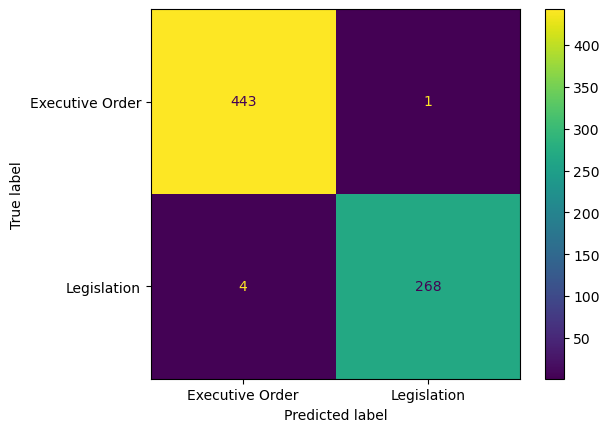

In [40]:
plot_cm(y_test, gs_nb)

We'll now take a look at the different words that were the most significant in classifying the different documents.

In [97]:
# instantiate vectorizer
# using params from grid search
tfidf_nb = TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(3, 3))
X_train_tfidf_nb = tfidf_nb.fit_transform(X_train)
X_test_tfidf_nb = tfidf_nb.transform(X_test)

# fitting to Naive Bayes classifier
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_tfidf_nb, y_train)
#y_pred_nb = nb.predict(X_test_tfidf_nb)

# Creating tfidf matrix:
X_tfidf_nb = tfidf_nb.transform(df['text_string'])
result_df = df.copy()
result_df.reset_index(inplace=True)
result_df["tfidf"] = X_tfidf_nb.toarray().tolist()
result_df.head()

,index,year,text_string,target,tokens,tfidf
0,0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1933,hereby ordered dated february far relates esta...,0,"[hereby, ordered, dated, february, far, relate...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [98]:
tfidf_nb.get_feature_names_out()

array(['0010601101ain laboratory independent', '001f 18e fighter',
       '001joint urgent operational', ..., 'zoonotic infectious disease',
       'état decree date', 'état decree military'], dtype=object)

Text(50.7222222222222, 0.5, '')

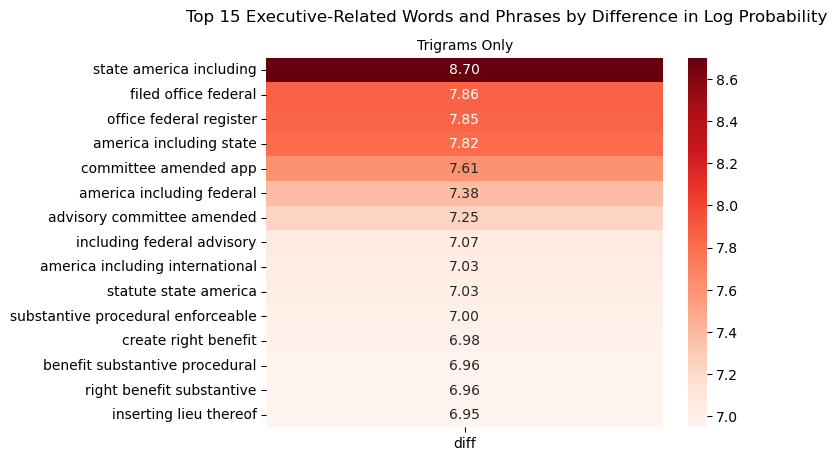

In [100]:
features_nb = pd.DataFrame((zip(tfidf_nb.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb["diff"] = features_nb[2] - features_nb[1]

heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=True)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Trigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


In [45]:
features_nb.sort_values(by="diff", ascending=True).head(50)

,0,1,2,diff
150043,hereby ordered,-6.214128,-14.435181,-8.221053
348874,vested constitution law,-6.286389,-14.435181,-8.148792
215061,ordered follows,-6.299232,-14.435181,-8.135949
150049,hereby ordered follows,-6.351601,-14.435181,-8.083580
348873,vested constitution,-6.250196,-14.152823,-7.902627
40611,authority vested constitution,-6.252689,-14.152611,-7.899922
40605,authority vested,-6.128887,-13.990842,-7.861955
24424,america including,-6.740008,-14.435181,-7.695173
309260,state america including,-6.741014,-14.435181,-7.694167
24413,america hereby,-6.915141,-14.435181,-7.520041


Words that we'll use to further filter the corpus:

Artefacts: "reaganthe"

Presidency-related: "commander", "chief"

Authority-related: "authority", "vested", "constitution"

Other: "state", "ordered", "follows", "hereby", "united", "states", "white", "house"

Text(50.7222222222222, 0.5, '')

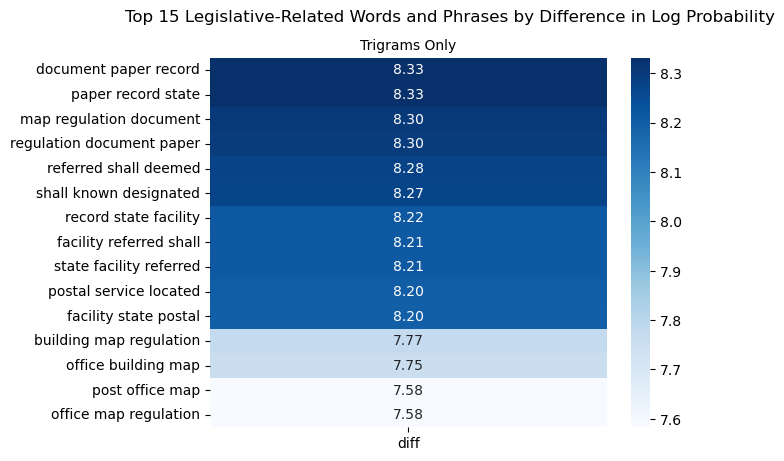

In [102]:
heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=False)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Trigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")

In [47]:
heatmap_nb.sort_values(by="diff", ascending=False).head(50)

,diff
word,
known designated,7.750651
paper record united,7.738578
document paper record,7.738564
paper record,7.737576
document paper,7.736548
law map,7.719844
law map regulation,7.719828
map regulation,7.719828
reference law map,7.719828


In [103]:
# Repeating the above process to get unigrams only
# instantiate vectorizer
# using params from grid search
tfidf_nb_unigrams = TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 1))
X_train_tfidf_nb_unigrams = tfidf_nb_unigrams.fit_transform(X_train)
X_test_tfidf_nb_unigrams = tfidf_nb_unigrams.transform(X_test)

# fitting to Naive Bayes classifier
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_tfidf_nb_unigrams, y_train)
#y_pred_nb = nb.predict(X_test_tfidf_nb)

# Creating tfidf matrix:
X_tfidf_nb = tfidf_nb_unigrams.transform(df['text_string'])
result_df_unigrams = df.copy()
result_df_unigrams.reset_index(inplace=True)
result_df_unigrams["tfidf"] = X_tfidf_nb.toarray().tolist()
result_df_unigrams.head(1)

,index,year,text_string,target,tokens,tfidf
0,0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Text(50.72222222222221, 0.5, '')

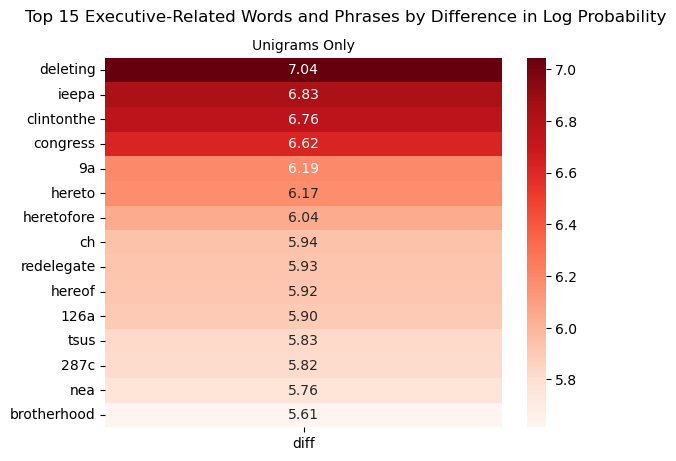

In [105]:
features_nb_unigrams = pd.DataFrame((zip(tfidf_nb_unigrams.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb_unigrams["diff"] = features_nb_unigrams[2] - features_nb_unigrams[1]

heatmap_nb_unigrams = features_nb_unigrams[[0, "diff"]].copy()
heatmap_nb_unigrams = heatmap_nb_unigrams.rename(columns={0: "word"})
heatmap_nb_unigrams = heatmap_nb_unigrams.sort_values(by="diff", ascending=True)
heatmap_nb_unigrams = heatmap_nb_unigrams.set_index("word")

sns.heatmap(heatmap_nb_unigrams[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


Text(50.72222222222221, 0.5, '')

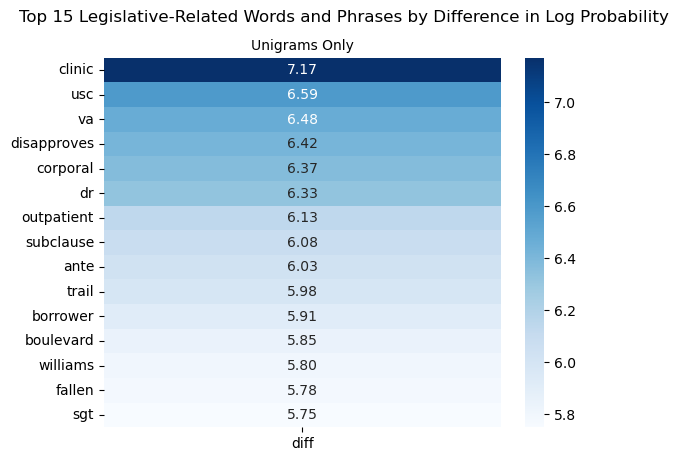

In [107]:
features_nb_unigrams = pd.DataFrame((zip(tfidf_nb_unigrams.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb_unigrams["diff"] = features_nb_unigrams[2] - features_nb_unigrams[1]

heatmap_nb_unigrams = features_nb_unigrams[[0, "diff"]].copy()
heatmap_nb_unigrams = heatmap_nb_unigrams.rename(columns={0: "word"})
heatmap_nb_unigrams = heatmap_nb_unigrams.sort_values(by="diff", ascending=False)
heatmap_nb_unigrams = heatmap_nb_unigrams.set_index("word")

sns.heatmap(heatmap_nb_unigrams[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


The unigrams are slightly odd -- in the executive case, there appear to be a lot of typos and artefacts of web-scraping. The legislative case reveals how many of the laws that Congress enacts have to do with the (re-)naming of Post Offices.

## 4.ii Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
# instantiate vectorizer
# using params from grid search

X = df[['text_string']]
y = df['target']

# creating a pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# setting up the parameters
param_grid_rf = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'rf__n_estimators': [100, 300],
    'rf__criterion': ['gini', 'log_loss'],
    'rf__max_depth': [None, 10, 50],
    #'rf__max_features': [None, 'sqrt', 'log2']
}

# grid search
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, n_jobs=-1)

In [51]:
gs_rf.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'log_loss'],
                         'rf__max_depth': [None, 10, 50],
                         'rf__n_estimators': [100, 300],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]})

In [52]:
evaluate_grid(gs_rf)

Best Params: {'rf__criterion': 'gini', 'rf__max_depth': 50, 'rf__n_estimators': 100, 'tfidf__max_df': 1.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best CV Accuracy: 0.9961536007884183
Train Accuracy: 1.0


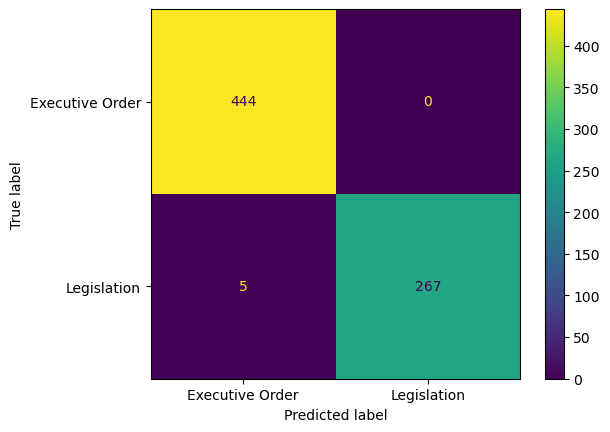

In [53]:
plot_cm(y_test, gs_rf)

In [54]:
feats = {} 
for feature, importance in zip(gs_rf.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_rf.best_estimator_.named_steps['rf'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).head(50)

,Gini-importance
vested,0.066850
hereby,0.050538
constitution,0.044900
ordered,0.037989
authority,0.034350
cited,0.031325
enactment,0.029984
america,0.021750
striking,0.018261
follows,0.017907


## 4.iii XGBoost

In [55]:
import xgboost as xgb
from xgboost import XGBClassifier

In [61]:
# creating a pipeline
pipe_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

# setting up the parameters
# starting with a basic xgb model; running two different solvers
param_grid_xgb = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1,3), (3, 3)],
    'xgb__booster': ['gbtree', 'gblinear'],
}

# grid search
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, n_jobs=-1)

In [62]:
gs_xgb.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)],
                         'xgb__booster': ['gbtree', 'gblinear']})

In [63]:
evaluate_grid(gs_xgb)

Best Params: {'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'xgb__booster': 'gbtree'}
Best CV Accuracy: 0.9954545454545454
Train Accuracy: 1.0


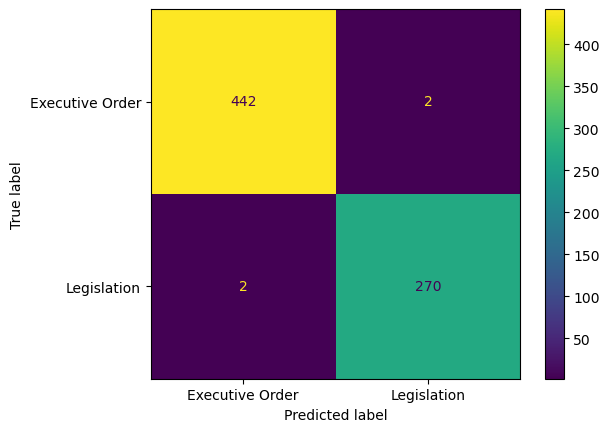

In [64]:
plot_cm(y_test, gs_xgb)

In [65]:
feats = {} 
for feature, importance in zip(gs_xgb.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_xgb.best_estimator_.named_steps['xgb'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).head(50)

,Gini-importance
authority vested,0.679708
whereas,0.054887
vested,0.051450
white house,0.016736
hereby ordered,0.014868
head department,0.010828
cleveland,0.010726
act may cited,0.010597
said,0.009550
hereby,0.007970


authority-related: "vested", "authorized"

executive order artefacts: "white", "house", 

quasi-authority-related: "whereas", "hereby",

too explicit to keep: "act", "law", "resolution"

procedural words: "cited", "reference", "subsection", "paragraph"

# 5. Adding Stopwords

We can now combine our lists of the words we want to filter:

"reaganthe", "commander", "chief", "white", "house", "authority", "vested", "constitution", "authorized", "whereas", "hereby", "united", "states", "ordered", "follows", "act", "law", "resolution", "cited", "reference", "subsection", "paragraph"

In [66]:
new_stops = ["reaganthe", "commander", "chief", "white", "house", "authority", "vested", "constitution", "authorized", "whereas", "hereby", "united", "states", "ordered", "follows", "act", "law", "resolution", "cited", "reference", "subsection", "paragraph"] + ["virtue", "section", "ii", "iii", "iv", "v", "vi", "title", "part"]
stops_extended_3 = stops_extended + new_stops
stops_extended_3

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [67]:
# recreating our function with our new stopwords
def clean_text_4(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended_3 and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [68]:
# applying the function to df
df_2 = df.copy()
df_2['cleaned_text'] = df_2['text_string'].apply(clean_text_4)
df_2['text_string'] = [' '.join(map(str, l)) for l in df_2['cleaned_text']]
df_2.head()

,year,text_string,target,tokens,cleaned_text
0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[august, gennerich, may, appointed, operative,..."
1,1933,canal zoneby building located cristobal canal ...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, located, cristobal, ..."
2,1933,october stat l amended march said march issue ...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amended, march, said, march..."
3,1933,legislative appropriation fiscal year amended ...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame..."
4,1933,dated february far relates establishment rio g...,0,"[hereby, ordered, dated, february, far, relate...","[dated, february, far, relates, establishment,..."


In [69]:
X = df_2['text_string']
y = df_2['target']

# repeat train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 5.i Multinomial Naive Bayes II

In [71]:
# create pipe
pipe_nb_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# params
param_grid_nb_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'tfidf__min_df': [1, 5, 10],
    'nb__alpha': [0.01, 0.1, 1]
}

# grid search
gs_nb_2 = GridSearchCV(pipe_nb_2, param_grid_nb_2, cv=5, n_jobs=-1)

In [72]:
gs_nb_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [73]:
evaluate_grid(gs_nb_2)

Best Params: {'nb__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (2, 2)}
Best CV Accuracy: 0.9898601398601399
Train Accuracy: 1.0


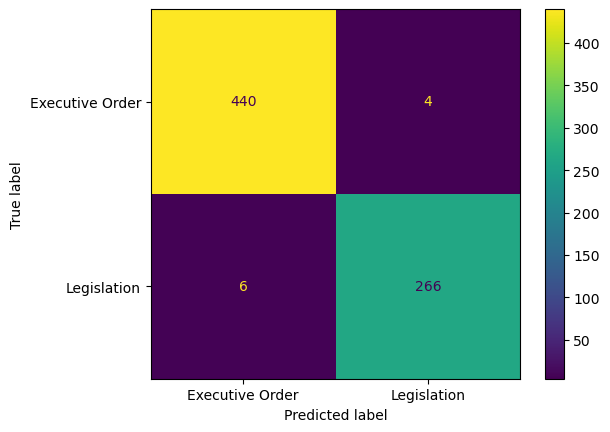

In [74]:
plot_cm(y_test, gs_nb_2)

Text(50.7222222222222, 0.5, '')

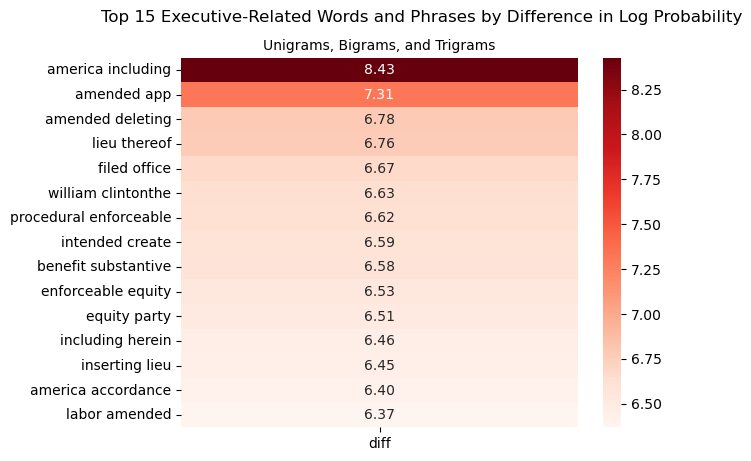

In [75]:
# repeating the process for getting most important features
features_nb_2 = pd.DataFrame((zip(gs_nb_2.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_nb_2.best_estimator_.named_steps['nb'].feature_log_prob_[0], gs_nb_2.best_estimator_.named_steps['nb'].feature_log_prob_[1])))
features_nb_2["diff"] = features_nb_2[2] - features_nb_2[1]

heatmap_nb_2 = features_nb_2[[0, "diff"]].copy()
heatmap_nb_2 = heatmap_nb_2.rename(columns={0: "word"})
heatmap_nb_2 = heatmap_nb_2.sort_values(by="diff", ascending=True)
heatmap_nb_2 = heatmap_nb_2.set_index("word")
heatmap_nb_2

sns.heatmap(heatmap_nb_2[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

In [76]:
features_nb_2.sort_values(by="diff", ascending=True).head(50)

,0,1,2,diff
68064,america including,-6.212994,-14.641133,-8.428139
66773,amended app,-7.190571,-14.503235,-7.312664
66870,amended deleting,-7.859976,-14.641133,-6.781157
497789,lieu thereof,-7.691064,-14.453460,-6.762395
364505,filed office,-7.229719,-13.898054,-6.668334
932816,william clintonthe,-8.013993,-14.641133,-6.627139
645824,procedural enforceable,-7.921833,-14.545249,-6.623416
462917,intended create,-7.973262,-14.563938,-6.590676
121727,benefit substantive,-7.964487,-14.542738,-6.578252
313958,enforceable equity,-8.082110,-14.615086,-6.532976


Text(50.7222222222222, 0.5, '')

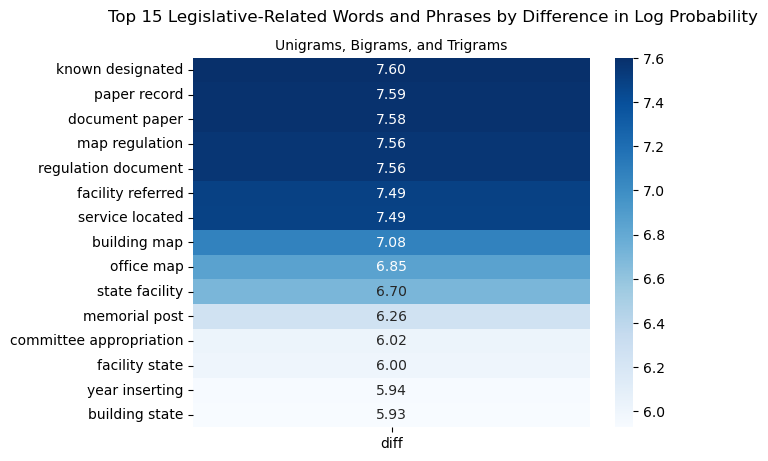

In [77]:
heatmap_nb_2 = features_nb_2[[0, "diff"]].copy()
heatmap_nb_2 = heatmap_nb_2.rename(columns={0: "word"})
heatmap_nb_2 = heatmap_nb_2.sort_values(by="diff", ascending=False)
heatmap_nb_2 = heatmap_nb_2.set_index("word")
heatmap_nb_2

sns.heatmap(heatmap_nb_2[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

## 5.ii RF II

In [78]:
pipe_rf_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# setting up the parameters
param_grid_rf_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1,2), (2, 2), (1, 3), (3, 3)],
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 10, 50],
}

# grid search
gs_rf_2 = GridSearchCV(pipe_rf_2, param_grid_rf_2, cv=3, n_jobs=-1)

In [79]:
gs_rf_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 50],
                         'rf__n_estimators': [100, 300],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [80]:
evaluate_grid(gs_rf_2)

Best Params: {'rf__max_depth': 50, 'rf__n_estimators': 300, 'tfidf__max_df': 1.0, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2)}
Best CV Accuracy: 0.9839148578581155
Train Accuracy: 0.9979020979020979


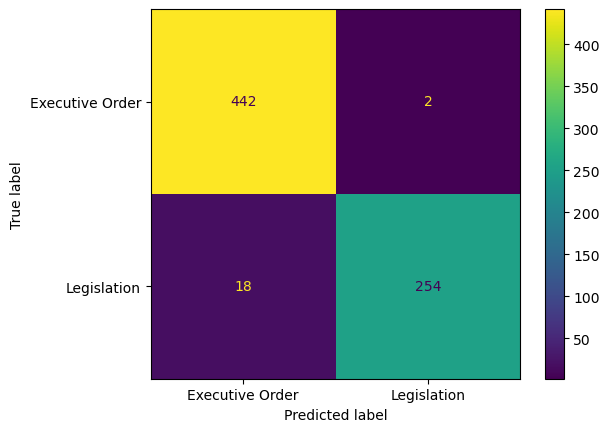

In [81]:
plot_cm(y_test, gs_rf_2)

In [82]:
def get_feature_importance(gs, model_name, vectorizer='tfidf'):
    feats = {} 
    for feature, importance in zip(gs.best_estimator_.named_steps[vectorizer].get_feature_names_out(), gs.best_estimator_.named_steps[model_name].feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    return importances.sort_values(by='Gini-importance', ascending=False).head(50)

In [83]:
get_feature_importance(gs_rf_2, 'rf', 'tfidf')

,Gini-importance
striking,0.019849
enactment,0.018066
america,0.017951
state america,0.016910
date enactment,0.016808
stat,0.008987
post,0.008748
inserting,0.008553
document,0.008551
located,0.008541


## 5.iii XGBoost II

In [84]:
# pipe
pipe_xgb_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

# params
param_grid_xgb_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'xgb__booster': ['gbtree', 'gblinear'],
}

# grid search
gs_xgb_2 = GridSearchCV(pipe_xgb_2, param_grid_xgb_2, cv=5, n_jobs=-1)


In [85]:
gs_xgb_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)],
                         'xgb__booster': ['gbtree', 'gblinear']})

In [86]:
evaluate_grid(gs_xgb_2)

Best Params: {'tfidf__max_df': 0.75, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2), 'xgb__booster': 'gbtree'}
Best CV Accuracy: 0.9877622377622378
Train Accuracy: 0.9996503496503496


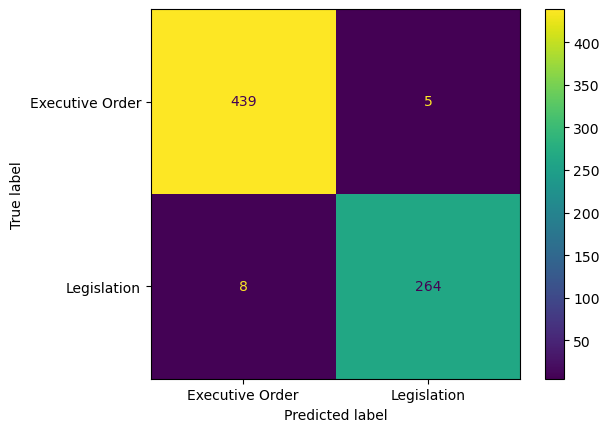

In [87]:
plot_cm(y_test, gs_xgb_2)

In [88]:
get_feature_importance(gs_xgb_2, 'xgb', 'tfidf')

,Gini-importance
state america,0.191461
map,0.126093
enactment,0.068881
paper,0.041711
therefore,0.032585
date enactment,0.028251
inserting,0.027308
submitted,0.027076
function,0.026412
congress,0.023658


# 6. Changes Over Time

## 6.i Multinomial Naive Bayes

In [89]:
# Using 2nd MNB Model
vectorizer = gs_nb_2.best_estimator_.named_steps['tfidf']
mnb_model = gs_nb_2.best_estimator_.named_steps['nb']

# Creating tfidf matrix:
X_tfidf = vectorizer.transform(df_2['text_string'])
result_df = df_2.copy()
result_df.reset_index(inplace=True)
result_df["tfidf"] = X_tfidf.toarray().tolist()
result_df.head()

,index,year,text_string,target,tokens,cleaned_text,tfidf
0,0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[august, gennerich, may, appointed, operative,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1933,canal zoneby building located cristobal canal ...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, located, cristobal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1933,october stat l amended march said march issue ...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amended, march, said, march...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1933,legislative appropriation fiscal year amended ...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1933,dated february far relates establishment rio g...,0,"[hereby, ordered, dated, february, far, relate...","[dated, february, far, relates, establishment,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [90]:
proba = mnb_model.predict_proba(X_tfidf)
result_df["proba"] = proba.tolist()
result_df["prob_0"] = [x[0] for x in result_df["proba"]]
result_df["prob_1"] = [x[1] for x in result_df["proba"]]
result_df["difference"] = result_df["prob_1"] - result_df["prob_0"]
result_df.head()

,index,year,text_string,target,tokens,cleaned_text,tfidf,proba,prob_0,prob_1,difference
0,0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[august, gennerich, may, appointed, operative,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9999836183459171, 1.6381654082286686e-05]",0.999984,1.638165e-05,-0.999967
1,1,1933,canal zoneby building located cristobal canal ...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, located, cristobal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9999992655690942, 7.34430906423482e-07]",0.999999,7.344309e-07,-0.999999
2,2,1933,october stat l amended march said march issue ...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amended, march, said, march...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9999999994919051, 5.080940673940058e-10]",1.000000,5.080941e-10,-1.000000
3,3,1933,legislative appropriation fiscal year amended ...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9999376938784972, 6.230612149742202e-05]",0.999938,6.230612e-05,-0.999875
4,4,1933,dated february far relates establishment rio g...,0,"[hereby, ordered, dated, february, far, relate...","[dated, february, far, relates, establishment,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9998571484520732, 0.00014285154792814303]",0.999857,1.428515e-04,-0.999714


In [91]:
# group data by year and target; calculate mean of difference
grouped_data = result_df.groupby(["year", "target"]).agg({"difference": "mean"}).abs().reset_index()

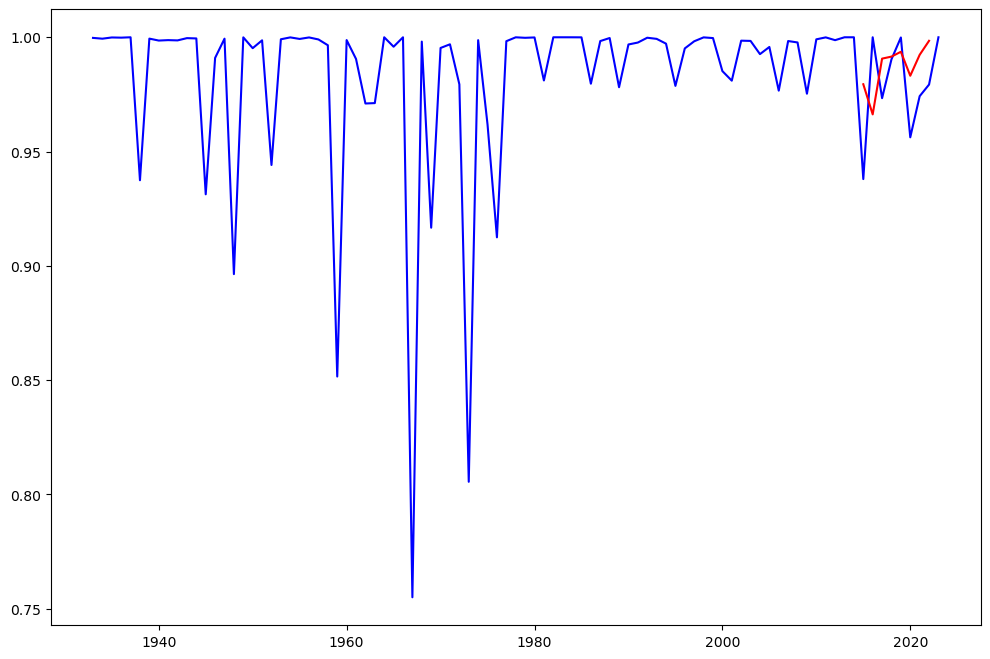

In [92]:
# plot
plt.figure(figsize=(12, 8))
for target, data in grouped_data.groupby("target"):
    if target == 0:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='red')

# 7. Conclusions

# 8. Next Steps